In [44]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
from trans import Dataset
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = Dataset('data/transcriptions/train.csv')
words_vocab = data.words_vocab
trans_vocab = data.trans_vocab

In [4]:
batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(32)

In [5]:
batch_words.device

device(type='cuda', index=0)

In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.gru = nn.GRU(emb_size, hidden_size, num_layers = 2, batch_first = True)
        
    def forward(self, source, source_lens = None):
        
        embedded = self.embedding(source)

        if source_lens is not None:
            embedded = pack(embedded, source_lens, batch_first=True)

        outs, hidden = self.gru(embedded)
        
        if source_lens is not None: 
            outs, _ = unpack(outs, batch_first=True)

        return outs, hidden
        
        
class DotAttentionNoCell(nn.Module):
    def __init__(self):
        super(DotAttentionNoCell, self).__init__()
        
        
    def forward(self, query, context, mask = None):
        '''
        Inputs:
            query:   (batch_size, dec_seq_len, hidden) - outputs of decoder
            context: (batch_size, enc_seq_len, hidden) - outputs of encoder
            mask:    (batch_size, enc_seq_len)
        Outputs:
            weights: (batch_size, dec_seq_len, enc_seq_len)
            outputs: (batch, dec_seq_len, hidden)
        '''
        logits = torch.matmul(query, context.transpose(1, 2))

        if mask is not None:

            mask = mask.unsqueeze(1).repeat(1, logits.size(1), 1)
            logits = logits.masked_fill(1 - mask, -10e10)

        weights = F.softmax(logits, dim = 2)
               
        outputs = torch.matmul(weights, context)

        return weights, outputs
    
class BahdanauAttentionNoCell(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttentionNoCell, self).__init__()
        
        self.W = nn.Linear(2 * hidden_size, hidden_size)
        self.v_a = nn.Linear(hidden_size, 1)
        
        
    def forward(self, dec_outputs, enc_outputs, mask = None):
        '''
        Inputs:
            query:   (batch_size, dec_seq_len, hidden) - outputs of decoder
            context: (batch_size, enc_seq_len, hidden) - outputs of encoder
            mask:    (batch_size, enc_seq_len)
            
        Outputs:
            weights: (batch_size, dec_seq_len, enc_seq_len)
            outputs: (batch, dec_seq_len, hidden)
        '''
        
        cat_enc_outputs = enc_outputs.unsqueeze(1).repeat(1, dec_outputs.size(1), 1, 1)
        dec_outputs = dec_outputs.unsqueeze(2).repeat(1, 1, enc_outputs.size(1), 1)

        hidden_concat = torch.cat((cat_enc_outputs, dec_outputs), 3)

        W = self.W(hidden_concat)
       
        W = torch.tanh(W)

        weights = self.v_a(W)
        
        weights = weights.squeeze(-1)
        
        if mask is not None:
            mask = mask.unsqueeze(1).repeat(1, dec_outputs.size(1), 1)
            weights = weights.masked_fill(1 - mask, -10e10)

        weights = torch.softmax(weights, dim = -1)

        context = torch.matmul(weights, enc_outputs)#.sum(1)    
             
        return weights, context

class GeneralAttentionNocell(nn.Module):
    def __init__(self, hidden_size):
        super(GeneralAttentionNocell, self).__init__()
        
        self.W = nn.Linear(2 * hidden_size, hidden_size)
        self.v_a = nn.Linear(hidden_size, 1)
        
        
    def forward(self, outputs, hidden, mask = None):
        '''
        Inputs:
            outputs: (batch_size, seq_len, hidden) - outputs of encoder
            hidden: (batch_size, hidden) - previous hidden state
            
        Outputs:
            weights: (batch_size, seq_len, 1)
            context: (batch, hidden)
        '''

        hidden =  hidden.unsqueeze(1).repeat(1, outputs.size(1), 1)

        hidden_concat = torch.cat((outputs, hidden), 2)
        W = self.W(hidden_concat)
        W = torch.tanh(W)
        
        weights = self.v_a(W)

        if mask is not None:
            mask = mask.unsqueeze(-1)
            weights = weights.masked_fill(1 - mask, -10e10)

        weights = torch.softmax(weights, dim = 2)

        context = (weights * outputs).sum(1)
        
        return weights, context
        
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, pad_idx):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)

        self.GRU = nn.GRU(emb_size, hidden_size, num_layers = 2,batch_first =  True)
        
        self.linear_1 = nn.Linear(2 * hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, vocab_size)
        
        self.attention = DotAttentionNoCell()
        
    def forward(self, enc_hidden, enc_outputs, target, mask):

        embedded = self.embedding(target)

        dec_outputs, hidden = self.GRU(embedded, enc_hidden)
        
        _, att_outputs = self.attention(dec_outputs, enc_outputs, mask)

        output = torch.cat((dec_outputs, att_outputs), dim = 2)

        linear_1 = self.linear_1(output)
        
        linear_1 = torch.tanh(linear_1)
        
        linear_2 = self.linear_2(linear_1)
        
        out = linear_2.view(-1, self.vocab_size)
        
                
        return out, hidden

In [7]:
encoder = Encoder(len(words_vocab), 32, 64, pad_idx=words_vocab.pad_idx)
decoder = Decoder(len(trans_vocab), 32, 64, pad_idx=words_vocab.pad_idx)

criterion = nn.CrossEntropyLoss()

encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())

In [8]:
num_epochs = 10
batch_size = 32
losses = []

In [9]:
class Model(nn.Module):
    def __init__(self, dataset, encoder, decoder, hidden_size, vocab_size):
        super(Model, self).__init__()
        self.dataset = dataset
        self.encoder = encoder
        self.decoder = decoder
        
        self.vocab_size = vocab_size
        
        
    def forward(self, batch_words, batch_trans_in, source_lens = None, mask = None):
        enc_outputs, hidden = self.encoder(batch_words, source_lens)

        out, hidden = self.decoder(hidden, enc_outputs, batch_trans_in, mask)
           
        return out   
    
    def generate(self, bos_idx, eos_idx, batch_words):
        inp = [bos_idx]
        outputs, hidden = self.encoder(batch_words)
        mask_words  = batch_words != 0
        

        for _ in range(100):
            inp_tensor = torch.LongTensor([[inp[-1]]]).to(batch_words.device)
            logits, hidden   = self.decoder(hidden, outputs, inp_tensor, mask_words)
            next_token = F.softmax(logits, dim=-1)[-1].topk(1)[1].item()
            inp.append(next_token)
            if next_token == eos_idx:
                break
        return inp

In [10]:
class Trainer:
    def __init__(self, dataset, model, encoder_optimizer, decoder_optimizer, criterion, batch_size):
        
        
        self.dataset = dataset
        self.train_losses = []
        self.val_losses = []
        self.batch_size = batch_size
        
        self.model = model
        self.encoder_optimizer = encoder_optimizer
        self.decoder_optimizer = decoder_optimizer
        self.criterion = criterion
        
               
    def train(self, n_epochs):
        
        mask_words = None
        for epoch in range(n_epochs):

            for batch_idx in range(len(self.dataset)//self.batch_size):

                batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = self.dataset.get_batch(32, sort = True)
                mask_words  = batch_words != 0
                
                logits = self.model(batch_words, batch_trans_in, words_lens, mask_words)

                batch_trans_out = batch_trans_out.view(-1)  
                mask = batch_trans_out != self.dataset.trans_vocab.pad_idx
                
                loss = self.criterion(logits[mask], batch_trans_out[mask])

                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()

                loss.backward()

                self.encoder_optimizer.step()
                self.decoder_optimizer.step()

                self.train_losses.append(loss.item())
                
                if batch_idx % 200 == 0:
                    val_loss = self.eval_()
                    self.val_losses.append(val_loss.item())
                    self.plot(epoch, batch_idx, self.train_losses, self.val_losses)
                  
        
    def eval_(self):
        
        val_words, val_trans_in, val_trans_out, val_words_lens, val_trans_lens = self.dataset.get_batch(32, sort = True, val = True)
        val_mask = val_words != 0
        logits = self.model(val_words, val_trans_in, val_words_lens, val_mask)
        val_trans_out = val_trans_out.view(-1)                

        mask = val_trans_out != trans_vocab.pad_idx

        loss = self.criterion(logits[mask], val_trans_out[mask])

        return loss
        
    def plot(self, epoch, batch_idx, train_losses, val_losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
        plt.plot(train_losses)
        plt.subplot(132)
        plt.title('epoch %s. | loss: %s' % (epoch, val_losses[-1]))
        plt.plot(val_losses)
        plt.show()  

In [11]:
model = Model(data, encoder, decoder, 64, len(trans_vocab)).to(device)
trainer = Trainer(data, model, encoder_optimizer, decoder_optimizer, criterion, batch_size = 32)

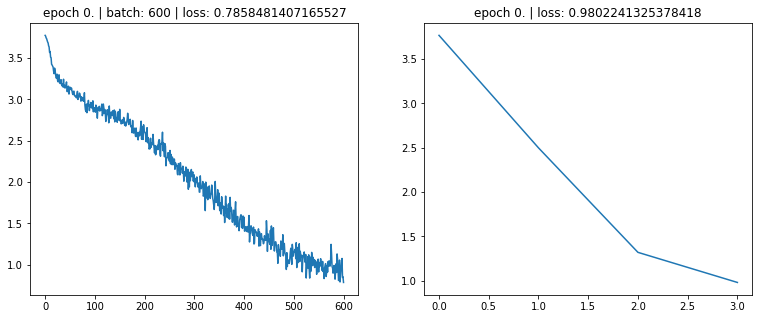

KeyboardInterrupt: 

In [12]:
trainer.train(4)

In [764]:
min(trainer.val_losses)

0.1685192584991455

In [765]:
def _print(val):
    batch_words, batch_trans_in, batch_trans_out, words_lens, trans_lens = data.get_batch(1, sort=True, val=val)
    batch_words     = batch_words.to(device)
    batch_trans_out = batch_trans_out.to(device)


    inp = model.generate(data.words_vocab.sos_idx, data.words_vocab.eos_idx, batch_words)
            
    tokens = [data.trans_vocab.idx2token(idx) for idx in inp if idx not in [data.trans_vocab.sos_idx,
                                                                       data.trans_vocab.eos_idx,
                                                                       data.trans_vocab.pad_idx]]
    print('Src: ', ''.join([data.words_vocab.idx2token(idx) for idx in batch_words[0].tolist()]))
    print('Pred:', ''.join(tokens))
    print('Real:', ''.join([data.trans_vocab.idx2token(idx) for idx in batch_trans_out[0].tolist() if idx not in [data.trans_vocab.sos_idx,
                                                                            data.trans_vocab.eos_idx,
                                                                            data.trans_vocab.pad_idx]]))

In [771]:
for _ in range(10):
    _print(True)
    print()

Src:  WIGINTON
Pred: WAYGIHNTAHN
Real: WIHJHIHNTAHN

Src:  DETTORE
Pred: DEHTER
Real: DIHTAORIY

Src:  NEEDHAM
Pred: NIYDAHM
Real: NIYDAHM

Src:  CALABRO
Pred: KAALAABROW
Real: KAHLAEBROW

Src:  BIGSBY
Pred: BIHGZBIY
Real: BIHGZBIY

Src:  PLAY
Pred: PLEY
Real: PLEY

Src:  SMEE
Pred: SMIY
Real: SMIY

Src:  CHOONG
Pred: CHUWNG
Real: CHUWNG

Src:  VOLUME
Pred: VOWLUWM
Real: VAALYUWM

Src:  COUNTERREVOLUTION
Pred: KAWNTERREHVAHLAHTIYAHSHAHN
Real: KAWNTERREHVAHLUWSHAHN

